In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint


2025-01-05 23:56:13.107589: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-05 23:56:13.144485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736117773.160808 1634394 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736117773.166535 1634394 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 23:56:13.186557: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Define the file paths
subdirectory = "pickle_data_Saisonbrot"
training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
test_labels_path = f"{subdirectory}/test_labels.pkl"

# Read the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
#test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
#print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())


Loaded Training features dimensions: (292, 24)
Loaded Validation features dimensions: (0, 24)
Loaded Test features dimensions: (56, 24)

Loaded Training labels dimensions: (292, 1)
Loaded Validation labels dimensions: (0, 1)

First few rows of loaded training features:
      Temp_Cold_current  Temp_Mild_current  Cloud_Clear_current  \
9042                  0                  1                    0   
9043                  0                  1                    0   
9044                  0                  1                    0   
9045                  0                  1                    0   
9046                  0                  1                    0   

      Cloud_Cloudy_current  Weather_Moderate_current  Samstag_current  \
9042                     0                         0                0   
9043                     1                         0                0   
9044                     0                         0                1   
9045                     1         

In [3]:
#Defining the Neural Network
#Now, let's define our neural network. We are using a Sequential model definition from Keras with batch normalization and dense layers.

model = Sequential([
    InputLayer(shape=(training_features.shape[1], )),
    Dropout(0.15),
    Dense(30, activation='relu', kernel_initializer="he_normal", kernel_regularizer=l2(0.1)),
    Dropout(0.15),
    Dense(20, activation='relu', kernel_initializer="he_normal", kernel_regularizer=l2(0.1)),

    Dense(1)
])

model.summary()

I0000 00:00:1736117775.232158 1634394 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 515 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,391 (5.43 KB)

 Trainable params: 1,391 (5.43 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# SGD with optimized parameters
optimizer = SGD(
    #learning_rate=0.003, durch den lr_scheduler geregelt
    momentum=0.9,    # Add momentum to help escape local minima
    nesterov=True,   # Use Nesterov momentum for better convergence
)

model.compile(
    loss="huber",    # More robust to outliers
    optimizer=optimizer,
    metrics=['mape']
)

# Custom learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 50.0
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return max(lr, 1e-5)  # Don't let LR get too small

history = model.fit(
    training_features, 
    training_labels, 
    epochs=70,
    batch_size=8,   # Smaller batch size works better with SGD
    verbose=1,
    validation_data=(validation_features, validation_labels),
    callbacks=[
        EarlyStopping(
            monitor='mape',
            patience=20,
            restore_best_weights=True,
            mode='min'
        ),
        LearningRateScheduler(lr_schedule),
        ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        )
    ]
)

Epoch 1/70


I0000 00:00:1736117777.663881 1634475 service.cc:148] XLA service 0x7fb0dc003520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736117777.663946 1634475 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-05 23:56:17.687800: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736117777.743196 1634475 cuda_dnn.cc:529] Loaded cuDNN version 90300


17/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 75.1701 - mape: 99.9528  

I0000 00:00:1736117778.995017 1634475 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 75.1157 - mape: 98.8550 - learning_rate: 0.0010
Epoch 2/70
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61.1280 - mape: 76.9470

2025-01-05 23:56:20.442096: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-05 23:56:20.442141: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-01-05 23:56:20.442150: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:20.442168: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928
/home/nolnmarten/workspace/code/machinelearning/bakery_sales_prediction/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batche

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 60.3463 - mape: 76.0216 - learning_rate: 0.0010
Epoch 3/70
25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.9764 - mape: 51.0298

2025-01-05 23:56:20.689022: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-01-05 23:56:20.689072: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:20.689094: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 35.7543 - mape: 49.4771 - learning_rate: 0.0010
Epoch 4/70
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.0000 - mape: 39.2181

2025-01-05 23:56:20.907804: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:20.907856: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928
2025-01-05 23:56:21.102935: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-01-05 23:56:21.102986: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:21.103012: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.0978 - mape: 39.5281 - learning_rate: 0.0010
Epoch 5/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.2140 - mape: 35.9860 - learning_rate: 0.0010
Epoch 6/70
19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.4655 - mape: 38.9804 

2025-01-05 23:56:21.254059: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:21.254111: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 28.7605 - mape: 38.6475 - learning_rate: 0.0010
Epoch 7/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.5193 - mape: 37.7139 - learning_rate: 0.0010
Epoch 8/70
 1/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 30.6583 - mape: 36.7493

2025-01-05 23:56:21.579557: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:21.579610: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928
2025-01-05 23:56:21.729281: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:21.729343: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.4373 - mape: 36.6635 - learning_rate: 0.0010
Epoch 9/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.4385 - mape: 33.0197 - learning_rate: 0.0010
Epoch 10/70


2025-01-05 23:56:21.916143: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-01-05 23:56:21.916183: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:21.916204: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928
2025-01-05 23:56:22.081838: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:22.081894: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.4296 - mape: 33.9029 - learning_rate: 0.0010
Epoch 11/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.7750 - mape: 36.7200 - learning_rate: 0.0010
Epoch 12/70


2025-01-05 23:56:22.260439: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:22.260501: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928
2025-01-05 23:56:22.435140: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:22.435201: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.9289 - mape: 32.3964 - learning_rate: 0.0010
Epoch 13/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.6393 - mape: 33.8545 - learning_rate: 0.0010
Epoch 14/70


2025-01-05 23:56:22.574178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:22.574333: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928
2025-01-05 23:56:22.739627: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:22.739697: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.0273 - mape: 36.1556 - learning_rate: 0.0010
Epoch 15/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.9606 - mape: 38.8150 - learning_rate: 0.0010
Epoch 16/70


2025-01-05 23:56:22.934855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:22.934911: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928
2025-01-05 23:56:23.113756: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:23.113805: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.9002 - mape: 35.0544 - learning_rate: 0.0010
Epoch 17/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.9378 - mape: 37.1206 - learning_rate: 0.0010
Epoch 18/70


2025-01-05 23:56:23.296827: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-01-05 23:56:23.296865: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:23.296885: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928
2025-01-05 23:56:23.483766: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:23.483811: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.3947 - mape: 38.1555 - learning_rate: 0.0010
Epoch 19/70
 1/37 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 20.1373 - mape: 46.4342

2025-01-05 23:56:23.680938: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:23.680995: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 21.9944 - mape: 36.6520 - learning_rate: 0.0010
Epoch 20/70
25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.1864 - mape: 40.4938

2025-01-05 23:56:24.060281: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:24.060338: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.0465 - mape: 39.1096 - learning_rate: 0.0010
Epoch 21/70
23/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.2681 - mape: 34.7637

2025-01-05 23:56:24.300136: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:24.300188: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20.8569 - mape: 35.5187 - learning_rate: 0.0010
Epoch 22/70
23/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.9045 - mape: 38.1044

2025-01-05 23:56:24.580096: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:24.580216: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.0406 - mape: 37.5357 - learning_rate: 0.0010
Epoch 23/70
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.9160 - mape: 42.7979

2025-01-05 23:56:24.857446: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:24.857495: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 22.8539 - mape: 42.5739 - learning_rate: 0.0010
Epoch 24/70
22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.2729 - mape: 33.3558

2025-01-05 23:56:25.180897: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:25.180957: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.5204 - mape: 34.2413 - learning_rate: 0.0010
Epoch 25/70
18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23.9905 - mape: 42.6781

2025-01-05 23:56:25.408038: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:25.408157: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 22.7904 - mape: 41.2318 - learning_rate: 0.0010
Epoch 26/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.1767 - mape: 33.1252

2025-01-05 23:56:25.714354: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:25.714401: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 19.2004 - mape: 33.1581 - learning_rate: 0.0010
Epoch 27/70
31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.1722 - mape: 34.2072

2025-01-05 23:56:26.035625: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:26.035689: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.0678 - mape: 34.1891 - learning_rate: 0.0010
Epoch 28/70
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.6138 - mape: 39.1565

2025-01-05 23:56:26.306635: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:26.306706: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.5824 - mape: 38.7599 - learning_rate: 0.0010
Epoch 29/70
31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.5673 - mape: 41.2398

2025-01-05 23:56:26.553063: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:26.553111: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.4539 - mape: 40.2723 - learning_rate: 0.0010
Epoch 30/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.8352 - mape: 38.9379

2025-01-05 23:56:26.804153: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:26.804201: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.8236 - mape: 38.8427 - learning_rate: 0.0010
Epoch 31/70
31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.1897 - mape: 32.7310

2025-01-05 23:56:27.035548: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:27.035654: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.6872 - mape: 33.4553 - learning_rate: 0.0010
Epoch 32/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.7734 - mape: 39.4457 - learning_rate: 0.0010
Epoch 33/70


2025-01-05 23:56:27.241921: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:27.242028: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928
2025-01-05 23:56:27.404733: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-01-05 23:56:27.404790: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:27.404813: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.8382 - mape: 35.4908 - learning_rate: 0.0010
Epoch 34/70
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.3605 - mape: 33.3376

2025-01-05 23:56:27.621729: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:27.621775: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.3583 - mape: 33.8093 - learning_rate: 0.0010
Epoch 35/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.4384 - mape: 36.3595 - learning_rate: 0.0010
Epoch 36/70


2025-01-05 23:56:27.865459: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:27.865532: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928
2025-01-05 23:56:28.044451: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:28.044498: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18.3456 - mape: 32.3345 - learning_rate: 0.0010
Epoch 37/70
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.4877 - mape: 42.1920

2025-01-05 23:56:28.320018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:28.320080: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.5359 - mape: 41.8412 - learning_rate: 0.0010
Epoch 38/70
10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.0539 - mape: 33.4659 

2025-01-05 23:56:28.564001: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:28.564052: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ -2s -48523us/step - loss: 19.6422 - mape: 33.9147 - learning_rate: 0.0010
Epoch 39/70
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.8558 - mape: 37.4799

2025-01-05 23:56:26.850180: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:26.850227: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19.9392 - mape: 37.1591 - learning_rate: 0.0010
Epoch 40/70
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.7309 - mape: 36.9111

2025-01-05 23:56:27.102640: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:27.102717: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.7113 - mape: 36.8300 - learning_rate: 0.0010
Epoch 41/70
25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.8574 - mape: 34.8918

2025-01-05 23:56:27.309876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:27.309930: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.5868 - mape: 35.1359 - learning_rate: 0.0010
Epoch 42/70
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.2432 - mape: 38.0765

2025-01-05 23:56:27.521938: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:27.522006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928
2025-01-05 23:56:27.715658: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:27.715705: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.0222 - mape: 37.6666 - learning_rate: 0.0010
Epoch 43/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 20.3337 - mape: 36.5752 - learning_rate: 0.0010
Epoch 44/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.5636 - mape: 40.6536 - learning_rate: 0.0010


2025-01-05 23:56:28.036384: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:28.036443: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928
2025-01-05 23:56:28.231254: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:28.231303: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


Epoch 45/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.0838 - mape: 34.1866 - learning_rate: 0.0010
Epoch 46/70
 1/37 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 20.1893 - mape: 29.9858

2025-01-05 23:56:28.421758: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:28.421853: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.3166 - mape: 32.2370 - learning_rate: 0.0010
Epoch 47/70
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.4812 - mape: 35.6917

2025-01-05 23:56:28.734391: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:28.734450: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928
2025-01-05 23:56:28.931081: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3726444105848127143
2025-01-05 23:56:28.931149: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8110257940450583928


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.4651 - mape: 35.7205 - learning_rate: 0.0010


In [5]:
# Saving the trained Model
model.save("python_model_Saisonbrot.h5")

In [6]:
# Making Predictions and Evaluating the Model
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


/home/nolnmarten/workspace/code/machinelearning/bakery_sales_prediction/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


ValueError: math domain error

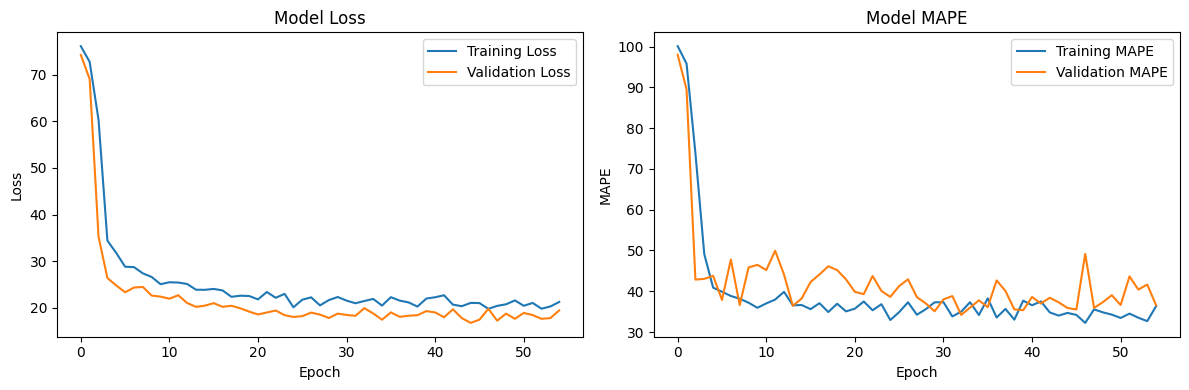

In [112]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='Training MAPE')
plt.plot(history.history['val_mape'], label='Validation MAPE')
plt.title('Model MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend()

plt.tight_layout()
plt.show()

<class 'numpy.ndarray'>


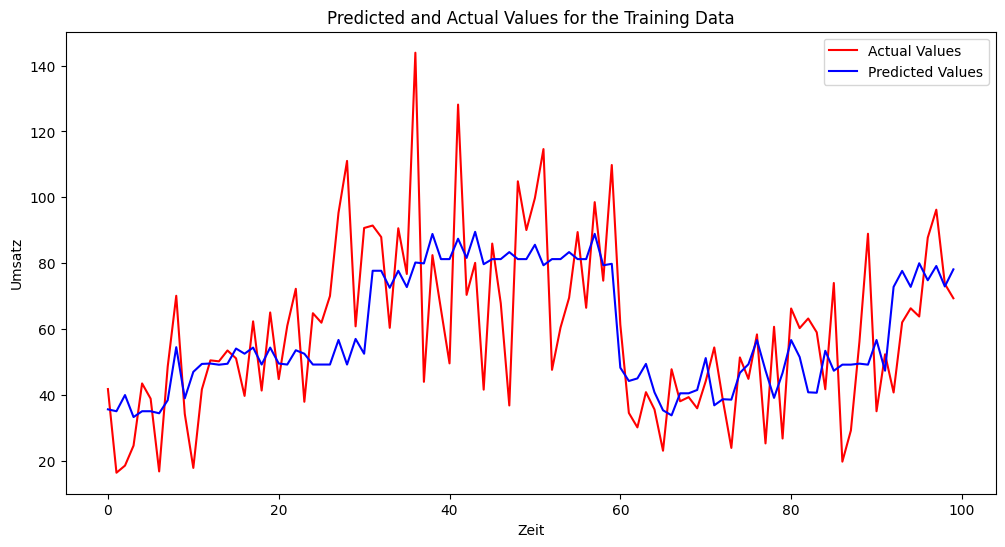

In [7]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Zeit')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
#validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
# validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
# print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
# data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
# plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

***VORHERSAGE TESTZEITRAUM***

In [9]:
test_predictions = model.predict(test_features)
#print("Predictions for test data:", test_predictions[:5])  # Display first 5 predictions
# Größe des Arrays anzeigen
print("Größe des Arrays (shape):", test_predictions.shape)
test_predictions = pd.DataFrame(test_predictions)
test_predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Größe des Arrays (shape): (56, 1)


,0
0,38.570724
1,38.116840
2,61.458015
3,49.506096
4,42.799809
5,46.449165
6,45.729740
7,37.807636
8,46.449165
9,44.885574


In [10]:
data_test = pd.read_csv("../../../0_DataPreparation/00_data/data_with_lag/Testdaten_with_lag.csv")
data_test = data_test[data_test["Warengruppe_6"] == 1]
data_test

,id,Datum,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,Temp_Very_Cold_current,Temp_Very_Cold_prev,...,zwischen_den_jahren_next,Number_of_ships_scaled_current,Number_of_ships_scaled_prev,Number_of_ships_scaled_next,Cloud_ok_current,Cloud_ok_prev,Cloud_ok_next,Wind_ok_current,Wind_ok_prev,Wind_ok_next
1774,1811016,2018-11-01,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.2,0.0,1,0.0,0.0,1,1.0,1.0
1775,1811026,2018-11-02,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.0,0.0,0,1.0,1.0,1,1.0,1.0
1776,1811036,2018-11-03,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.0,0.0,1,0.0,0.0,1,1.0,1.0
1777,1811046,2018-11-04,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.0,0.2,0,1.0,0.0,1,1.0,1.0
1778,1811056,2018-11-05,0,0,0,0,0,1,0,0.0,...,0.0,0.2,0.0,0.2,0,0.0,0.0,1,1.0,1.0
1779,1811066,2018-11-06,0,0,0,0,0,1,0,0.0,...,0.0,0.2,0.2,0.4,0,0.0,1.0,1,1.0,1.0
1780,1811076,2018-11-07,0,0,0,0,0,1,0,0.0,...,0.0,0.4,0.2,1.0,1,0.0,0.0,1,1.0,1.0
1781,1811086,2018-11-08,0,0,0,0,0,1,0,0.0,...,0.0,1.0,0.4,0.2,0,1.0,0.0,1,1.0,1.0
1782,1811096,2018-11-09,0,0,0,0,0,1,0,0.0,...,0.0,0.2,1.0,0.0,0,0.0,0.0,1,1.0,1.0
1783,1811106,2018-11-10,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.2,0.0,0,0.0,0.0,1,1.0,1.0


In [11]:
# Erstelle Ziel csv Datei

predictions_df = pd.DataFrame({
    'id': data_test['id'].values,
    'Umsatz': test_predictions[0].values
}).reset_index(drop=True)

# Save to a CSV file
#output_csv_path = "/workspaces/bakery_sales_prediction/3_Model/02_Franz/V3_lag/Umsatzvorhersage_Saisonbrot_Hochladeformat.csv"

predictions_df.to_csv('Saisonbrot_Umsatzvorhersage.csv', index=False)
print(f"CSV Datei erstellt")

CSV Datei erstellt
